In [5]:
from ucimlrepo import fetch_ucirepo
import seaborn as sb
import matplotlib.pyplot as plt
import pandas as pd
import scipy.stats as stats

In [6]:
#N -> Nominal Data
#O -> Ordinal Data
#D -> Discrete Data
#C -> Continous Data
data_type = {"age":"C" 
            ,"sex":"N" #Binomial
            ,"cp": "N"
            ,"trestbps": "C"
            ,"chol": "C"
            ,"fbs": "N"
            ,"restecg": "N"
            ,"thalach": "C"
            ,"exang": "N" #Binomial
            ,"oldpeak": "C"
            ,"slope": "N"
            ,"ca":"D"
            ,"thal": "N"
            ,"diagnosis":"N"}

In [7]:
# fetch dataset 
heart_disease = fetch_ucirepo(id=45) 

# data (as pandas dataframes) 
X = heart_disease.data.features 
y = heart_disease.data.targets
y = y.rename(columns={"num":"diagnosis"})

data = X.join(y)

In [8]:
def type_comparison(a, b):
    comp = -1
    comp = 0 if a == b == "N" else comp
    comp = 1 if a == b == "C" else comp
    comp = 1 if a == b == "D" else comp

    comp = 2 if (a == "N" and b == "C") or (a == "C" and b == "N") else comp
    comp = 2 if (a == "N" and b == "D") or (a == "D" and b == "N") else comp
    comp = 1 if (a == "D" and b == "C") or (a == "C" and b == "D") else comp

    return comp

In [9]:
def nominal_corr(a, b):

    return 0

In [10]:
def numeric_corr(a, b) : return a.corr(b, 'pearson')

In [ ]:
def nom_num_corr(a,b):
    categories = a.unique().tolist()

    data = {"a":a, "b":b}
    df = pd.concat(data, axis = 1)
    df = df.sort_values(by='a')
    df.set_index(keys=['a'], drop=False, inplace=True)

    print(df)

    vals = []
    for i in categories:
        vals.append(df.loc[df.a==i])


    print(stats.f_oneway(vals))



    return 0

In [41]:
correlation_matrix = []
for i_name, i, in data.items():
    cur_row = []
    for j_name, j in data.items():
        daty_comp = type_comparison(data_type[i_name], data_type[j_name])
        
        if i_name == j_name:
            cur_row.append(1)
            continue

        match daty_comp:
            case 0:
                cur_row.append(nominal_corr(i, j))
            case 1:
                cur_row.append(numeric_corr(i, j))
            case 2:
                
                cur_row.append(nom_num_corr(i, j)) if data_type[i_name] == "N" else cur_row.append(nom_num_corr(j, i))

    cur_row = [round(elem, 2) for elem in cur_row]
    correlation_matrix.append(cur_row)

AttributeError: 'DataFrame' object has no attribute 'a'

<Axes: >

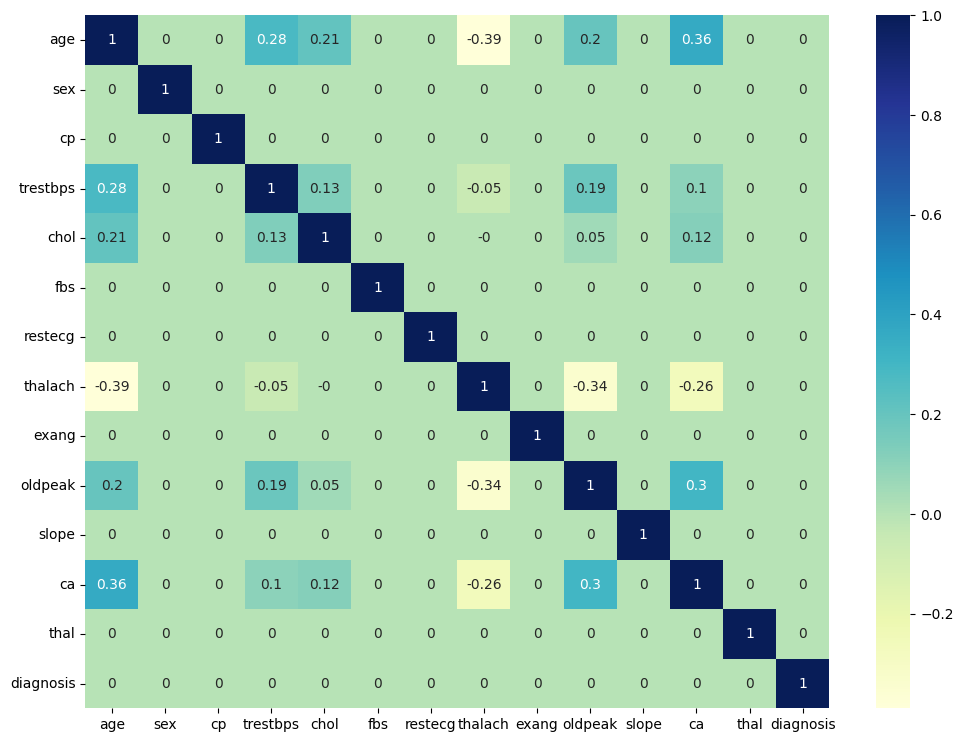

In [18]:
plt.figure(figsize = (12, 9))
sb.heatmap(correlation_matrix, cmap="YlGnBu", annot=True, yticklabels=data.columns.tolist(), xticklabels=data.columns.tolist())